In [1]:
from keras.layers.core import Layer
import tensorflow as tf
import numpy as np


Using TensorFlow backend.


In [2]:
from keras.layers import (Activation, Dense, Dropout, Flatten,
                          Lambda, MaxPooling2D)
from keras.layers.convolutional import Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential, model_from_json
from keras.regularizers import l2
from keras.utils import np_utils


In [3]:
class SpatialTransformer(Layer):
 

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        #self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*(width_float)
        y = .5*(y + 1.0)*(height_float)

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
        y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?
        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

        # transformed_grid = tf.batch_matmul(affine_transformation, indices_grid)
        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                                x_s_flatten,
                                                y_s_flatten,
                                                output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                output_height,
                                                                output_width,
                                                                num_channels))
        return transformed_image

In [4]:
def locnet():
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((64, 6), dtype='float32')
    weights = [W, b.flatten()]
    locnet = Sequential()

    locnet.add(Conv2D(16, (7, 7), padding='valid', input_shape=(32, 32, 3)))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(32, (5, 5), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))
    locnet.add(Conv2D(64, (3, 3), padding='valid'))
    locnet.add(MaxPooling2D(pool_size=(2, 2)))

    locnet.add(Flatten())
    locnet.add(Dense(128))
    locnet.add(Activation('elu'))
    locnet.add(Dense(64))
    locnet.add(Activation('elu'))
    locnet.add(Dense(6, weights=weights))

    return locnet

In [5]:
def conv_model(input_shape=(32, 32, 3)):
    model = Sequential()
    model.add(Lambda(
        lambda x: x/127.5 - 1.,
        input_shape=(32, 32, 3),
        output_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(10, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(Conv2D(3, (1, 1), padding='same', kernel_regularizer=l2(0.05)))
    model.add(LeakyReLU(alpha=0.5))
    model.add(BatchNormalization())
    model.add(SpatialTransformer(localization_net=locnet(),
                                 output_size=(32, 32)))
    model.add(Conv2D(16, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(96, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(192, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (5, 5), padding='same', activation='relu', kernel_regularizer=l2(0.05)))
    model.add(MaxPooling2D(pool_size=(8, 8)))
    model.add(Flatten())
    model.add(Dropout(0.6))
    model.add(Dense(43, activation="softmax"))
    return model

In [6]:
import pickle
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam



training_file = 'C:/Users/goutham1996/Desktop/data/input/train.p'
testing_file = 'C:/Users/goutham1996/Desktop/data/input/test.p'
validating_file = 'C:/Users/goutham1996/Desktop/data/input/valid.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validating_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print("Number of training examples =", X_train.shape[0])
print("Number of validating examples =", X_valid.shape[0])
print("Number of testing examples =", X_test.shape[0])
print("Image data shape =", X_train[0].shape)
print("Number of classes =", len(np.unique(y_train)))



Number of training examples = 34799
Number of validating examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [13]:
print(y_train)

[41 41 41 ... 25 25 25]


In [9]:
batch_size = 128
epochs = 150
model = conv_model()

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])



In [ ]:
checkpointer = ModelCheckpoint(filepath="C:/Users/goutham1996/Desktop/data/output/weights.hdf5", verbose=1, save_best_only=True, save_weights_only=True)
try:
    model.fit(X_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_data=(X_valid, y_valid),
                shuffle=True,
                callbacks=[checkpointer])
except KeyboardInterrupt:
    print("training interrupted")

In [10]:
model.load_weights("C:/Users/goutham1996/Desktop/data/output/weights.hdf5")
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9958828186856691


C:\Users\goutham1996\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
C:\Users\goutham1996\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


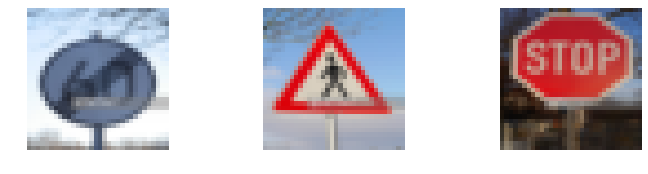

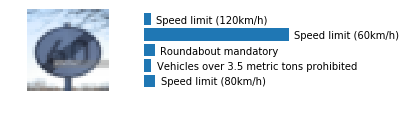

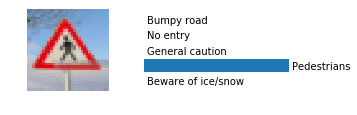

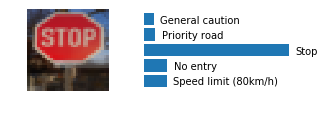

In [13]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from scipy.misc import imread, imresize
import pandas as pd
import glob




model = conv_model()
model.load_weights("C:/Users/goutham1996/Desktop/data/output/weights.hdf5")
image_names = glob.glob('C:/Users/goutham1996/Desktop/data/signs/*.jpg')
SignNames = pd.read_csv('C:/Users/goutham1996/Desktop/data/input/signnames.csv')

X_sample_new = []
for image_name in image_names:
    img = imread(image_name)
    img = imresize(img, (32, 32))
    X_sample_new.append(img)

X_sample_new = np.array(X_sample_new)
## examine the results
gs1 = gridspec.GridSpec(4, 3)
gs1.update(wspace=0.005, hspace=0.01) # set the spacing between axes.
plt.figure(figsize=(12,12))
for i in range(3):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    plt.subplot(4,3,i+1)
    plt.imshow(X_sample_new[i])
    plt.axis('off')

y_prob = model.predict(X_sample_new)
for i in range(3):
    plt.figure(figsize = (5,1.5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[2,3])
    plt.subplot(gs[0])
    plt.imshow(X_sample_new[i])
    plt.axis('off')
    plt.subplot(gs[1])
    top5_ind = np.argpartition(y_prob[i], -5)[-5:]
    plt.barh(6-np.arange(5),y_prob[i][top5_ind], align='center')
    for i_label in range(5):
        plt.text(y_prob[i][top5_ind][i_label]+.02,6-i_label-.25,
            SignNames[SignNames['ClassId'] == top5_ind[i_label]]['SignName'].values[0])
    plt.axis('off')
    plt.show()